# Neural network based integrator simulating SHO system

In [ ]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt
from Code.dynamical_system import *
from Code.time_integrator import *
from Code.neuralnet import *

np.random.seed(2512517)

## Neural network integrator

Set system parameters, construct dynamical system and integrator.

The model system we are using here is the harmonic oscillator.
The timestep size of the Neural network integrator takes values in $\Delta t_{\text{Verlet}},20\Delta t_{\text{Verlet}},40\Delta t_{\text{Verlet}},100\Delta t_{\text{Verlet}}$ where $\Delta t_{\text{Verlet}}$ is the step size of the Verlet integrator that is used for training.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 2)]       0           []                               
                                                                                                  
 flatten (Flatten)              (None, 8)            0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 64)           576         ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                              

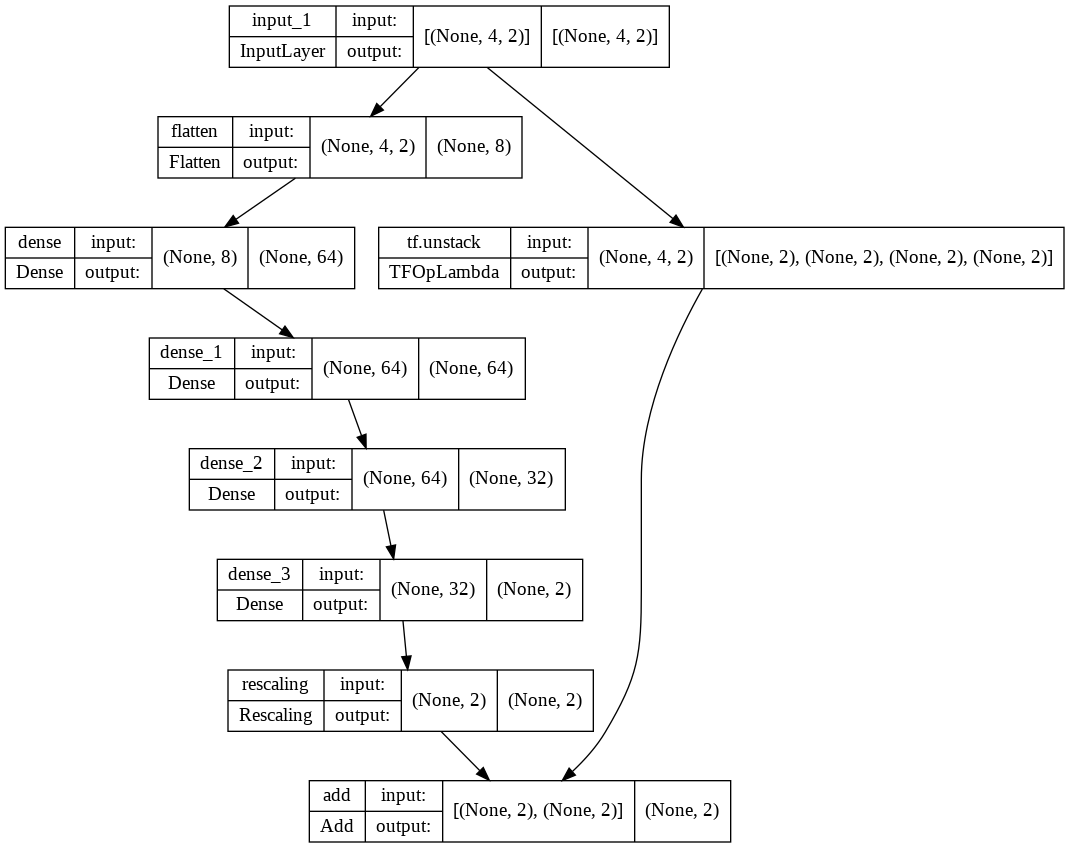

In [ ]:
# mass of particle
mass = 1.2
# spring constant of harmonic oscillator
k_spring = 0.9
# timestep for Verlet integrator
dt_verlet = 0.005
# timestep for neural network integrator
dt_1 = dt_verlet
dt_2 = 20*dt_verlet
dt_3 = 40*dt_verlet
dt_4 = 100*dt_verlet
# number of steps for neural network integrator
nsteps = 4

harmonic_oscillator = HarmonicOscillator(mass,k_spring)

verlet_SHO = VerletIntegrator(harmonic_oscillator,dt_verlet)

nn_integrator_1 = NN5LR3Integrator(harmonic_oscillator,nsteps,dt_1)
nn_integrator_2 = NN5LR3Integrator(harmonic_oscillator,nsteps,dt_2)
nn_integrator_3 = NN5LR3Integrator(harmonic_oscillator,nsteps,dt_3)
nn_integrator_4 = NN5LR3Integrator(harmonic_oscillator,nsteps,dt_4)

# visualise the neural network model
nn_integrator_1.model.summary()
keras.utils.plot_model(nn_integrator_1.model, show_shapes=True)

In [ ]:
BATCH_SIZE=64

data_generator_1 = DataGenerator(nn_integrator_1,verlet_SHO)
train_batches_1 = data_generator_1.dataset.batch(BATCH_SIZE)

data_generator_2 = DataGenerator(nn_integrator_2,verlet_SHO)
train_batches_2 = data_generator_2.dataset.batch(BATCH_SIZE)

data_generator_3 = DataGenerator(nn_integrator_3,verlet_SHO)
train_batches_3 = data_generator_3.dataset.batch(BATCH_SIZE)

data_generator_4 = DataGenerator(nn_integrator_4,verlet_SHO)
train_batches_4 = data_generator_4.dataset.batch(BATCH_SIZE)


## Train neural network based integrator

In [ ]:
EPOCHS=300
STEPS_PER_EPOCH=100
log_dir = './tb_logs/'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

result_1 = nn_integrator_1.model.fit(train_batches_1,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_2 = nn_integrator_2.model.fit(train_batches_2,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)
result_3 = nn_integrator_3.model.fit(train_batches_3,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                callbacks=tensorboard_cb)
result_4 = nn_integrator_4.model.fit(train_batches_4,epochs=EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,
                                 callbacks=tensorboard_cb)


Epoch 1/300
 91/100 [==========================>...] - ETA: 0s - loss: 4.7504e-05

## Visualise Loss function

In [ ]:
#print(result.history.keys())

plt.rcParams['figure.figsize'] = [10, 10]

# summarize history for loss
plt.plot(result_1.history['loss'])
plt.plot(result_2.history['loss'])
plt.plot(result_3.history['loss'])
plt.plot(result_4.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.legend(['$\Delta_v$','$20\Delta_v$','$40\Delta_v$','$100\Delta_v$'], loc='upper left')
plt.yscale("log")
plt.show()

## Plot trajectories generated to $t=32$ by Verlet integrator and neural 


In [ ]:
# Final time
T_final = 32

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.70
v[0] = -0.6
verlet_SHO.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_SHO = []
x_verlet_SHO = []
v_verlet_SHO = []
E_verlet_SHO = []



while t<T_final:
    t_verlet_SHO.append(t)
    E_verlet_SHO.append(verlet_SHO.energy())
    x_verlet_SHO.append(verlet_SHO.x[0])
    v_verlet_SHO.append(verlet_SHO.v[0])
    verlet_SHO.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
x_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))
v_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))



verlet_SHO.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_SHO.x[:]
    v_initial_1[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_1/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_SHO.x[:]
    v_initial_2[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_2/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_SHO.x[:]
    v_initial_3[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_3/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_4.nsteps):    
    x_initial_4[k,:] = verlet_SHO.x[:]
    v_initial_4[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_4/dt_verlet))


nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt
nn_integrator_4.set_state(x_initial_4,v_initial_4)
t_4 = (nn_integrator_4.nsteps-1)*nn_integrator_4.dt



# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []
t_nn_4 = []
x_nn_4 = []
v_nn_4 = []
E_nn_4 = []


while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    v_nn_1.append(nn_integrator_1.v[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt_1
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    v_nn_2.append(nn_integrator_2.v[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt_2
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x[0])
    v_nn_3.append(nn_integrator_3.v[0])
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt_3
while t_4<T_final:
    t_nn_4.append(t_4)
    x_nn_4.append(nn_integrator_4.x[0])
    v_nn_4.append(nn_integrator_4.v[0])
    E_nn_4.append(nn_integrator_4.energy())
    nn_integrator_4.integrate(1)
    t_4 += dt_4
 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_nn_4 = np.array(x_nn_4)
x_verlet_SHO = np.array(x_verlet_SHO)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_nn_4 = np.array(v_nn_4)
v_verlet_SHO = np.array(v_verlet_SHO)


# Plot position error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1-x_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(x_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,x_nn_4-x_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity error as a function of time

plt.plot(t_nn_1,v_nn_1-v_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(v_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,v_nn_4-v_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

plt.plot(t_nn_1,((v_nn_1-v_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2+(x_nn_1-x_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2)**0.5,label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(v_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2+(x_nn_2-x_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(x_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2)**0.5,label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2+(x_nn_3-x_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2)**0.5,label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,((v_nn_4-v_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2+(x_nn_4-x_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2)**0.5,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_SHO,E_verlet_SHO-E_verlet_SHO[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,E_nn_4-E_nn_4[0],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

#subplots of position versus velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_SHO,v_verlet_SHO,label='Verlet',color='black')
plt.plot(x_nn_1,v_nn_1,label='$\Delta_v$',color='blue')
plt.plot(x_nn_2,v_nn_2,label='$20\Delta_v$',color='orange')
plt.plot(x_nn_3,v_nn_3,label='$40\Delta_v$',color='green')
plt.plot(x_nn_4,v_nn_4,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('Velocity $v(t)$')
ax.set_xlabel('Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

## Plot trajectories generated to $t=128$ by Verlet integrator and neural 


In [ ]:
# Final time
T_final = 128

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.70
v[0] = -0.6
verlet_SHO.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_SHO = []
x_verlet_SHO = []
v_verlet_SHO = []
E_verlet_SHO = []



while t<T_final:
    t_verlet_SHO.append(t)
    E_verlet_SHO.append(verlet_SHO.energy())
    x_verlet_SHO.append(verlet_SHO.x[0])
    v_verlet_SHO.append(verlet_SHO.v[0])
    verlet_SHO.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
x_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))
v_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))



verlet_SHO.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_SHO.x[:]
    v_initial_1[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_1/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_SHO.x[:]
    v_initial_2[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_2/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_SHO.x[:]
    v_initial_3[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_3/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_4.nsteps):    
    x_initial_4[k,:] = verlet_SHO.x[:]
    v_initial_4[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_4/dt_verlet))


nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt
nn_integrator_4.set_state(x_initial_4,v_initial_4)
t_4 = (nn_integrator_4.nsteps-1)*nn_integrator_4.dt



# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []
t_nn_4 = []
x_nn_4 = []
v_nn_4 = []
E_nn_4 = []


while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    v_nn_1.append(nn_integrator_1.v[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt_1
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    v_nn_2.append(nn_integrator_2.v[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt_2
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x[0])
    v_nn_3.append(nn_integrator_3.v[0])
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt_3
while t_4<T_final:
    t_nn_4.append(t_4)
    x_nn_4.append(nn_integrator_4.x[0])
    v_nn_4.append(nn_integrator_4.v[0])
    E_nn_4.append(nn_integrator_4.energy())
    nn_integrator_4.integrate(1)
    t_4 += dt_4
 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_nn_4 = np.array(x_nn_4)
x_verlet_SHO = np.array(x_verlet_SHO)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_nn_4 = np.array(v_nn_4)
v_verlet_SHO = np.array(v_verlet_SHO)


# Plot position error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1-x_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet)::int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet):int(np.size(x_verlet_SHO)-dt_3/dt_verlet):int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,x_nn_4-x_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity error as a function of time

plt.plot(t_nn_1,v_nn_1-v_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet)::int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet):int(np.size(v_verlet_SHO)-dt_3/dt_verlet):int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,v_nn_4-v_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

plt.plot(t_nn_1,((v_nn_1-v_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2+(x_nn_1-x_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2)**0.5,label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet)::int(dt_2/dt_verlet)])**2+(x_nn_2-x_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet)::int(dt_2/dt_verlet)])**2)**0.5,label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet):int(np.size(v_verlet_SHO)-dt_3/dt_verlet):int(dt_3/dt_verlet)])**2+(x_nn_3-x_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet):int(np.size(x_verlet_SHO)-dt_3/dt_verlet):int(dt_3/dt_verlet)])**2)**0.5,label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,((v_nn_4-v_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2+(x_nn_4-x_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2)**0.5,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_SHO,E_verlet_SHO-E_verlet_SHO[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,E_nn_4-E_nn_4[0],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

#subplots of position versus velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_SHO,v_verlet_SHO,label='Verlet',color='black')
plt.plot(x_nn_1,v_nn_1,label='$\Delta_v$',color='blue')
plt.plot(x_nn_2,v_nn_2,label='$20\Delta_v$',color='orange')
plt.plot(x_nn_3,v_nn_3,label='$40\Delta_v$',color='green')
plt.plot(x_nn_4,v_nn_4,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('Velocity $v(t)$')
ax.set_xlabel('Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()

## Plot trajectories generated to $t=512$ by Verlet integrator and neural 


In [ ]:
# Final time
T_final = 512

# Initial conditions
x = np.zeros(1)
v = np.zeros(1)
x[0] = 2.70
v[0] = -0.6
verlet_SHO.set_state(x,v)

# ==== Verlet integrator ====
t = 0.0
t_verlet_SHO = []
x_verlet_SHO = []
v_verlet_SHO = []
E_verlet_SHO = []



while t<T_final:
    t_verlet_SHO.append(t)
    E_verlet_SHO.append(verlet_SHO.energy())
    x_verlet_SHO.append(verlet_SHO.x[0])
    v_verlet_SHO.append(verlet_SHO.v[0])
    verlet_SHO.integrate(1)
    t += dt_verlet
        

# ==== Neural network integrator ====

# Initialise with Verlet integrator
x_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
v_initial_1 = np.zeros((nn_integrator_1.nsteps,nn_integrator_1.dynamical_system.dim))
x_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
v_initial_2 = np.zeros((nn_integrator_2.nsteps,nn_integrator_2.dynamical_system.dim))
x_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
v_initial_3 = np.zeros((nn_integrator_3.nsteps,nn_integrator_3.dynamical_system.dim))
x_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))
v_initial_4 = np.zeros((nn_integrator_4.nsteps,nn_integrator_4.dynamical_system.dim))



verlet_SHO.set_state(x,v)
for k in range(nn_integrator_1.nsteps):    
    x_initial_1[k,:] = verlet_SHO.x[:]
    v_initial_1[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_1/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_2.nsteps):    
    x_initial_2[k,:] = verlet_SHO.x[:]
    v_initial_2[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_2/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_3.nsteps):    
    x_initial_3[k,:] = verlet_SHO.x[:]
    v_initial_3[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_3/dt_verlet))
verlet_SHO.set_state(x,v)
for k in range(nn_integrator_4.nsteps):    
    x_initial_4[k,:] = verlet_SHO.x[:]
    v_initial_4[k,:] = verlet_SHO.v[:]
    verlet_SHO.integrate(int(dt_4/dt_verlet))


nn_integrator_1.set_state(x_initial_1,v_initial_1)
t_1 = (nn_integrator_1.nsteps-1)*nn_integrator_1.dt
nn_integrator_2.set_state(x_initial_2,v_initial_2)
t_2 = (nn_integrator_2.nsteps-1)*nn_integrator_2.dt
nn_integrator_3.set_state(x_initial_3,v_initial_3)
t_3 = (nn_integrator_3.nsteps-1)*nn_integrator_3.dt
nn_integrator_4.set_state(x_initial_4,v_initial_4)
t_4 = (nn_integrator_4.nsteps-1)*nn_integrator_4.dt



# Timestepping loop
t_nn_1 = []
x_nn_1 = []
v_nn_1 = []
E_nn_1 = []
t_nn_2 = []
x_nn_2 = []
v_nn_2 = []
E_nn_2 = []
t_nn_3 = []
x_nn_3 = []
v_nn_3 = []
E_nn_3 = []
t_nn_4 = []
x_nn_4 = []
v_nn_4 = []
E_nn_4 = []


while t_1<T_final:
    t_nn_1.append(t_1)
    x_nn_1.append(nn_integrator_1.x[0])
    v_nn_1.append(nn_integrator_1.v[0])
    E_nn_1.append(nn_integrator_1.energy())
    nn_integrator_1.integrate(1)
    t_1 += dt_1
while t_2<T_final:
    t_nn_2.append(t_2)
    x_nn_2.append(nn_integrator_2.x[0])
    v_nn_2.append(nn_integrator_2.v[0])
    E_nn_2.append(nn_integrator_2.energy())
    nn_integrator_2.integrate(1)
    t_2 += dt_2
while t_3<T_final:
    t_nn_3.append(t_3)
    x_nn_3.append(nn_integrator_3.x[0])
    v_nn_3.append(nn_integrator_3.v[0])
    E_nn_3.append(nn_integrator_3.energy())
    nn_integrator_3.integrate(1)
    t_3 += dt_3
while t_4<T_final:
    t_nn_4.append(t_4)
    x_nn_4.append(nn_integrator_4.x[0])
    v_nn_4.append(nn_integrator_4.v[0])
    E_nn_4.append(nn_integrator_4.energy())
    nn_integrator_4.integrate(1)
    t_4 += dt_4
 



x_nn_1 = np.array(x_nn_1)
x_nn_2 = np.array(x_nn_2)
x_nn_3 = np.array(x_nn_3)
x_nn_4 = np.array(x_nn_4)
x_verlet_SHO = np.array(x_verlet_SHO)
v_nn_1 = np.array(v_nn_1)
v_nn_2 = np.array(v_nn_2)
v_nn_3 = np.array(v_nn_3)
v_nn_4 = np.array(v_nn_4)
v_verlet_SHO = np.array(v_verlet_SHO)


# Plot position error as a function of time
plt.clf()
plt.rcParams['figure.figsize'] = [10, 10]

plt.plot(t_nn_1,x_nn_1-x_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,x_nn_2-x_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(x_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,x_nn_3-x_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,x_nn_4-x_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('position Error $x_{NN}(t)-x_V(t)$')
ax.set_title('Position Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot velocity error as a function of time

plt.plot(t_nn_1,v_nn_1-v_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,v_nn_2-v_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(v_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,v_nn_3-v_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,v_nn_4-v_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('Velocity Error $v_{NN}(t)-v_V(t)$')
ax.set_title('Velocity Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()

# Plot L2 error as a function of time

plt.plot(t_nn_1,((v_nn_1-v_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2+(x_nn_1-x_verlet_SHO[int((nsteps-1)*dt_1/dt_verlet)::int(dt_1/dt_verlet)])**2)**0.5,label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,((v_nn_2-v_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(v_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2+(x_nn_2-x_verlet_SHO[int((nsteps-1)*dt_2/dt_verlet):int(np.size(x_verlet_SHO)-dt_2/dt_verlet):int(dt_2/dt_verlet)])**2)**0.5,label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,((v_nn_3-v_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2+(x_nn_3-x_verlet_SHO[int((nsteps-1)*dt_3/dt_verlet)::int(dt_3/dt_verlet)])**2)**0.5,label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,((v_nn_4-v_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(v_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2+(x_nn_4-x_verlet_SHO[int((nsteps-1)*dt_4/dt_verlet):int(np.size(x_verlet_SHO)-dt_4/dt_verlet):int(dt_4/dt_verlet)])**2)**0.5,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('L2 Error')
ax.set_title('L2 Error')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
#plt.grid()
plt.show()


plt.clf()
# Plot energy as a function of time
# (subtract energy at time t=0 to show energy drift)

plt.plot(t_verlet_SHO,E_verlet_SHO-E_verlet_SHO[0],label='Verlet',color='black')
plt.plot(t_nn_1,E_nn_1-E_nn_1[0],label='$\Delta_v$',color='blue')
plt.plot(t_nn_2,E_nn_2-E_nn_2[0],label='$20\Delta_v$',color='orange')
plt.plot(t_nn_3,E_nn_3-E_nn_3[0],label='$40\Delta_v$',color='green')
plt.plot(t_nn_4,E_nn_4-E_nn_4[0],label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_xlabel('time $t$')
ax.set_ylabel('energy shift $E(t)-E(t_0)$')
#ax.grid()
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

plt.show()

#subplots of position versus velocity for all 4

plt.rcParams['figure.figsize'] = [10, 10]

plt.clf()
plt.plot(x_verlet_SHO,v_verlet_SHO,label='Verlet',color='black')
plt.plot(x_nn_1,v_nn_1,label='$\Delta_v$',color='blue')
plt.plot(x_nn_2,v_nn_2,label='$20\Delta_v$',color='orange')
plt.plot(x_nn_3,v_nn_3,label='$40\Delta_v$',color='green')
plt.plot(x_nn_4,v_nn_4,label='$100\Delta_v$',color='red')
plt.legend(loc='upper left')
ax = plt.gca()
ax.set_ylabel('Velocity $v(t)$')
ax.set_xlabel('Position $q(t)$')
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title
plt.show()